In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

### Define static values 

In [2]:
folder = "run_results"

# Baseline was estimate using randomly_shuffled_evaluation.py (run 10 x)
baseline = dict({
    "accuracy": 0.2501,
    "kappa": 0.0174,
    "f1-score": 0.1717
})

metrics = ["accuracy", "kappa", "f1-score"]
boxplot_kwargs = {"boxprops": dict(alpha=0.5), "fliersize": 3}
modes = ["central", "federated", "local"]

## Load data

In [3]:
def load_data(id):
    homo_df = pd.read_csv(os.path.join(folder, f"{id}_homogeneous.csv"))
    homo_df["dataset"] = "homogeneous"
    hetero_df = pd.read_csv(os.path.join(folder, f"{id}_heterogeneous.csv"))
    hetero_df["dataset"] = "heterogeneous"
    TMA_df = pd.read_csv(os.path.join(folder, f"{id}_TMA.csv"))
    TMA_df["dataset"] = "TMA"

    df = pd.concat([homo_df, hetero_df, TMA_df], ignore_index=True)
    return df

def add_local_all(df):
    local_rows = df[df["mode"].str.contains("TMA|spl")].copy()
    local_rows["mode"] = "local"
    df = pd.concat([df, local_rows], ignore_index=True)
    return df

In [4]:
uni_df = load_data("uni")
uni_df["model"] = "UNI"

conch_df = load_data("conch")
conch_df["model"] = "CONCH"

ecarenet_df = add_local_all(load_data("ecarenet"))
ecarenet_df["model"] = "eCaReNet"

full_df = pd.concat([ecarenet_df, uni_df, conch_df], ignore_index=True)

In [5]:
full_df.head()

,mode,run_id,best_epoch,replicate,accuracy,kappa,f1-score,test_dataset,accuracy_TMA20,kappa_TMA20,f1-score_TMA20,dataset,model
0,central,297.0,453,1.0,0.548931,0.699276,0.451473,spl_1,0.435897,0.599443,0.370360,homogeneous,eCaReNet
1,central,298.0,208,1.0,0.505062,0.743109,0.452178,spl_2,0.466667,0.644788,0.434281,homogeneous,eCaReNet
2,central,299.0,312,1.0,0.513363,0.689763,0.431824,spl_3,0.476923,0.673405,0.436159,homogeneous,eCaReNet
3,central,306.0,275,2.0,0.554556,0.703341,0.445511,spl_1,0.456410,0.619608,0.395711,homogeneous,eCaReNet
4,central,307.0,103,2.0,0.505062,0.746437,0.444929,spl_2,0.441026,0.666023,0.403101,homogeneous,eCaReNet


## Figure 4

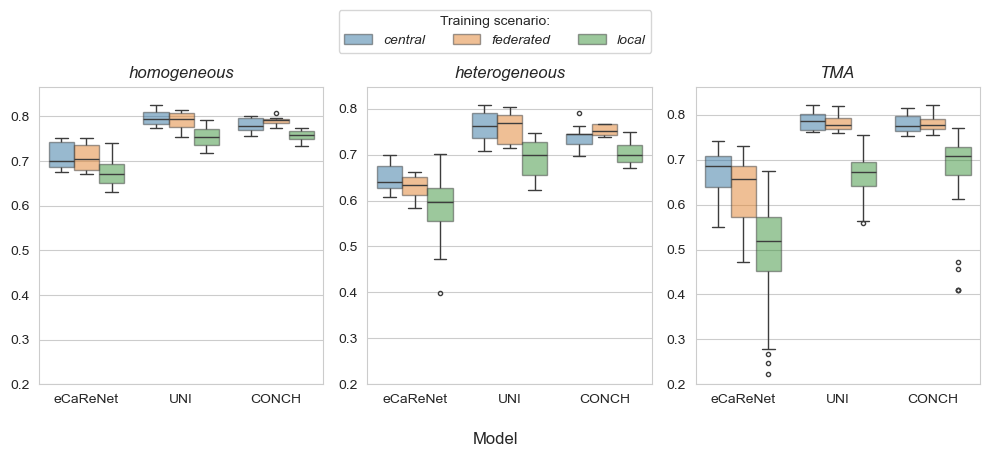

In [6]:
def create_figure4(df, metric):
    df = df[df["mode"].isin(["central", "federated", "local"])]
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i, dataset in enumerate(df["dataset"].unique()):
        t_df = df[df["dataset"] == dataset]
        sns.boxplot(x="model", y=metric, hue="mode", dodge=True, data=t_df, ax=axes[i], **boxplot_kwargs)

        axes[i].axhline(baseline[metric], linestyle="--", linewidth=1)
        axes[i].set_title(dataset, style="italic")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        axes[i].legend().remove()

        if metric == "kappa":
            axes[i].set_ylim(bottom=0.2)
    
    fig.supxlabel("Model")
    handles, labels = axes[0].get_legend_handles_labels()
    new_handles = [handles[i] for i in range(3)]
    new_labels = [labels[i] for i in range(3)]
    fig.legend(new_handles, new_labels, loc="upper center", title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.12), prop={'style': 'italic'})
    
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(os.path.join(folder, f"Compare_models_{metric}.png"), dpi=600, bbox_inches="tight")

create_figure4(full_df, "kappa")

## Results

In [7]:
def average_drop_mode(df, metric):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["dataset"] == "homogeneous"]
    average_metric = t_df.groupby(['mode', 'model'])[metric].mean().reset_index()
    pivoted = average_metric.pivot(index='model', columns='mode', values=metric)
    cent = (pivoted["local"] - pivoted["central"]) / pivoted["central"] * 100
    fed = (pivoted["local"] - pivoted["federated"]) / pivoted["federated"] * 100

    mi = min(min(cent), min(fed))
    ma = max(max(cent), max(fed))

    print(f"average performance increases between {mi:.1f}% and {ma:.1f}% for the local runs")

average_drop_mode(full_df, "accuracy")
average_drop_mode(full_df, "kappa")
average_drop_mode(full_df, "f1-score")


average performance increases between -10.3% and -2.0% for the local runs
average performance increases between -5.4% and -3.2% for the local runs
average performance increases between -10.5% and -5.5% for the local runs


In [8]:
def average_drop_models(df, metric):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["dataset"] == "homogeneous"]
    average_metric = t_df.groupby(["mode", "model"])[metric].mean().reset_index()
    pivoted = average_metric.pivot(index='mode', columns='model', values=metric)
    uni = (pivoted["UNI"] - pivoted["eCaReNet"]) / pivoted["eCaReNet"] * 100
    conch = (pivoted["CONCH"] - pivoted["eCaReNet"]) / pivoted["eCaReNet"] * 100

    mi = min(min(uni), min(conch))
    ma = max(max(uni), max(conch))

    print(f"Average performance increases for foundation models between {mi:.1f}% and {ma:.1f}% compared to eCaReNet")

average_drop_models(full_df, "accuracy")
average_drop_models(full_df, "kappa")
average_drop_models(full_df, "f1-score")

Average performance increases for foundation models between 8.1% and 17.4% compared to eCaReNet
Average performance increases for foundation models between 10.3% and 12.3% compared to eCaReNet
Average performance increases for foundation models between 29.0% and 36.3% compared to eCaReNet


In [9]:
def average_drop_datasplits(df):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]

    for model in t_df["model"].unique():
        tma_l = list()
        hetero_l = list()
        for metric in ["accuracy", "kappa", "f1-score"]:
            average_metric = t_df.groupby(["mode", "model", "dataset"])[metric].mean().reset_index()
            temp = average_metric[average_metric["model"] == model]
            pivoted = temp.pivot(index='mode', columns='dataset', values=metric)

            hetero = (pivoted["heterogeneous"] - pivoted["homogeneous"]) / pivoted["homogeneous"] * 100
            tma = (pivoted["TMA"] - pivoted["homogeneous"]) / pivoted["homogeneous"] * 100
            hetero_l.extend(hetero)
            tma_l.extend(tma)

        print(f"For model: {model}")
        print(f"Heterogenous data split mean performance increase {np.mean(hetero_l):.1f}%")
        print(f"TMA data split mean performance increase {np.mean(tma_l):.1f}%")
        print()

average_drop_datasplits(full_df)

For model: eCaReNet
Heterogenous data split mean performance increase -13.1%
TMA data split mean performance increase -13.4%

For model: UNI
Heterogenous data split mean performance increase -9.2%
TMA data split mean performance increase -5.3%

For model: CONCH
Heterogenous data split mean performance increase -9.3%
TMA data split mean performance increase -3.7%



In [10]:
def drop_ecarenet_federated(df):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["model"] == "eCaReNet"]

    central_l = list()
    local_l = list()
    for metric in ["accuracy", "kappa", "f1-score"]:
        temp = t_df.groupby(["mode", "model", "dataset"])[metric].mean().reset_index()

        pivoted = temp.pivot(index='dataset', columns='mode', values=metric)

        print(pivoted)

        central = (pivoted["central"] - pivoted["federated"]) / pivoted["central"] * 100
        local = (pivoted["local"] - pivoted["federated"]) / pivoted["federated"] * 100
        central_l.extend(central)
        local_l.extend(local)

        
    print(f"Central models {np.mean(central_l):.1f}%")
    print(f"Local models {np.mean(local_l):.1f}%")
    print()

drop_ecarenet_federated(full_df)

mode            central  federated     local
dataset                                     
TMA            0.518945   0.450584  0.411343
heterogeneous  0.474370   0.448928  0.431105
homogeneous    0.528797   0.510555  0.500343
mode            central  federated     local
dataset                                     
TMA            0.670925   0.631652  0.508970
heterogeneous  0.649964   0.628425  0.586529
homogeneous    0.708542   0.707644  0.674031
mode            central  federated     local
dataset                                     
TMA            0.428959   0.366182  0.307539
heterogeneous  0.389522   0.364657  0.343463
homogeneous    0.443659   0.447983  0.419424
Central models 5.7%
Local models -8.2%



In [11]:
def performance_range_local(df):
    t_df = df[df["mode"].isin(["local"])]
    t_df = t_df[t_df["model"] == "eCaReNet"]

    for metric in ["accuracy", "kappa", "f1-score"]:
        mi = t_df[metric].min()
        ma = t_df[metric].max()
        
        print(metric)
        print(f"Max performance {np.mean(mi):.5f}")
        print(f"Min performance {np.mean(ma):.5f}")
        print(f"Range: {ma-mi:.2f}")
        print()

performance_range_local(full_df)

accuracy
Max performance 0.24803
Min performance 0.52418
Range: 0.28

kappa
Max performance 0.22185
Min performance 0.73970
Range: 0.52

f1-score
Max performance 0.16465
Min performance 0.45926
Range: 0.29



## Supplement

In [12]:
def get_pivot(df, metric):
    grouped = df.groupby(["dataset", "mode", "model"])[metric].agg(["mean", "std"]).reset_index()
    grouped["mean"] = grouped["mean"].round(2)
    grouped["std"] = grouped["std"].round(3)

    pivot = grouped.pivot_table(index=["dataset", "mode"],
                                columns="model",
                                values=["mean", "std"])
    pivot.columns = [f"{model}_{stat}" for stat, model in pivot.columns]

    column_order = ["eCaReNet_mean", "eCaReNet_std", "UNI_mean", "UNI_std", "CONCH_mean", "CONCH_std"]
    pivot = pivot[column_order]
    print(pivot)

table_df = full_df[~full_df["mode"].str.startswith(("TMA", "spl"))]
get_pivot(table_df, "accuracy")
get_pivot(table_df, "kappa")
get_pivot(table_df, "f1-score")

                         eCaReNet_mean  eCaReNet_std  UNI_mean  UNI_std  \
dataset       mode                                                        
TMA           central             0.52         0.032      0.60    0.023   
              federated           0.45         0.048      0.59    0.026   
              local               0.41         0.060      0.47    0.066   
heterogeneous central             0.47         0.052      0.55    0.059   
              federated           0.45         0.061      0.53    0.026   
              local               0.43         0.069      0.46    0.053   
homogeneous   central             0.53         0.020      0.60    0.013   
              federated           0.51         0.025      0.60    0.018   
              local               0.50         0.015      0.54    0.017   

                         CONCH_mean  CONCH_std  
dataset       mode                              
TMA           central          0.61      0.030  
              federated    

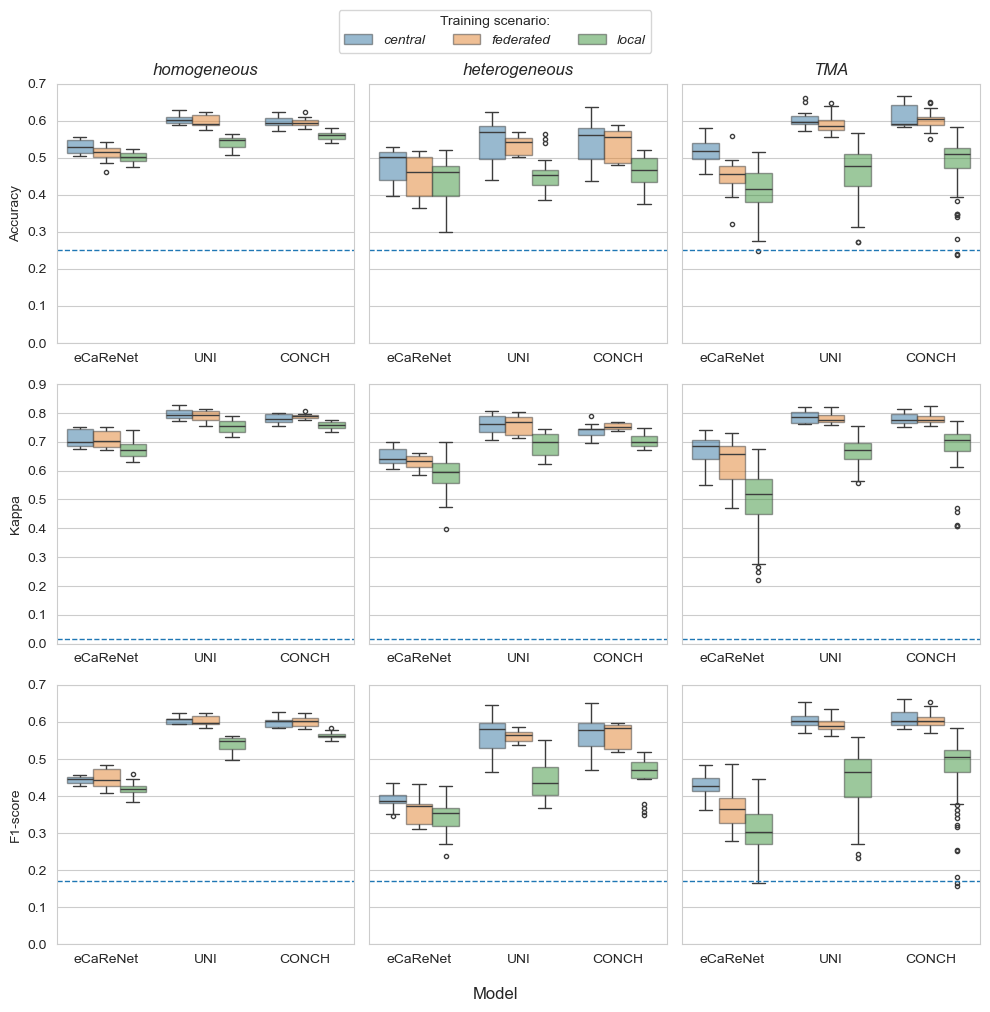

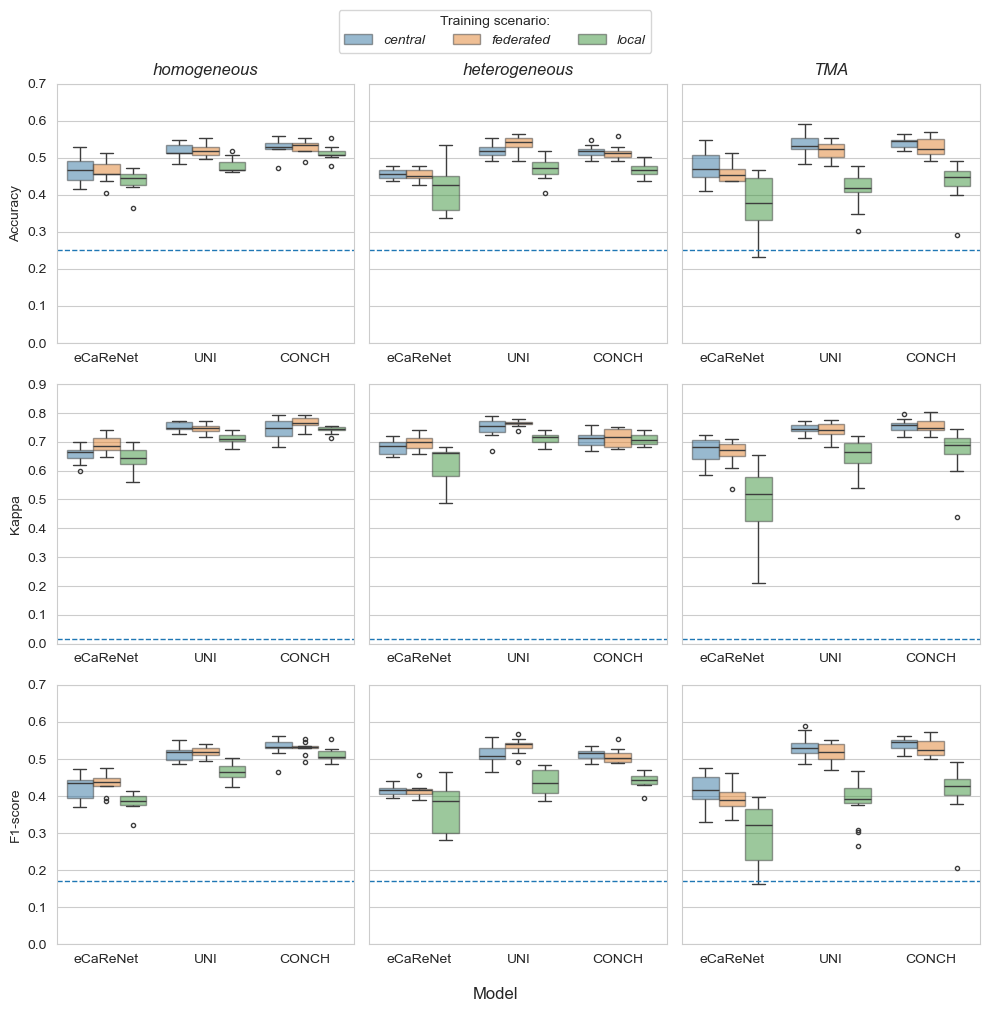

In [13]:
def create_supp_figure(df, use_tma20=False):
    df = df[df["mode"].isin(["central", "federated", "local"])]
    fig, axes = plt.subplots(3, 3, figsize=(10, 9), sharey="row")

    for i, metric in enumerate(["accuracy", "kappa", "f1-score"]):
        for j, dataset in enumerate(df["dataset"].unique()):
            t_df = df[df["dataset"] == dataset]
            if use_tma20:
                sns.boxplot(x="model", y=f"{metric}_TMA20", hue="mode", dodge=True, data=t_df, ax=axes[i][j], **boxplot_kwargs)
            else:
                sns.boxplot(x="model", y=metric, hue="mode", dodge=True, data=t_df, ax=axes[i][j], **boxplot_kwargs)

            axes[i][j].axhline(baseline[metric], linestyle="--", linewidth=1)
            axes[i][j].set_xlabel("")
            axes[i][j].set_ylabel("")
            axes[i][j].legend().remove()

            if i == 0:
                axes[i][j].set_title(dataset, style="italic")

        axes[i][0].set_ylabel(f"{metric.capitalize()}")
    
    axes[0][0].set_ylim(top=0.7, bottom=0.0)
    axes[1][0].set_ylim(top=0.9, bottom=0.0)
    axes[2][0].set_ylim(top=0.7, bottom=0.0)
    fig.supxlabel("Model")

    handles, labels = axes[0][0].get_legend_handles_labels()
    new_handles = [handles[i] for i in range(3)]
    new_labels = [labels[i] for i in range(3)]
    fig.legend(new_handles, new_labels, loc="upper center", title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.12), prop={'style': 'italic'})
    
    plt.tight_layout(rect=[0, 0, 1, 1.07])
    if use_tma20:
        filename = "Supp_compare_models_TMA20.png"
    else:
        filename = "Supp_compare_models.png"
    plt.savefig(os.path.join(folder, filename), dpi=600, bbox_inches="tight")


create_supp_figure(full_df)
create_supp_figure(full_df, use_tma20=True)

## Discussion

In [14]:
def direct_comparisions(df, dataset):
    print()
    print(dataset)
    df = df[df["dataset"] == dataset]
    for model in df["model"].unique():
        t_df = df[df["model"] == model]
        
        cent = t_df[t_df["mode"] == "central"]
        fed = t_df[t_df["mode"] == "federated"]
        local = t_df[t_df["mode"] == "local"]
        
        results = list()
        for m in metrics:
            l_m = local[m].mean()
            c_m = cent[m].mean()
            f_m = fed[m].mean()

            l_f_diff = (f_m - l_m) / f_m*100
            l_c_diff = (c_m - l_m) / c_m*100
            results.extend([l_f_diff, l_c_diff])

        print(f"{model}\t{min(results):.0f}% - {max(results):.0f}%")


direct_comparisions(full_df, "homogeneous")
direct_comparisions(full_df, "heterogeneous")
direct_comparisions(full_df, "TMA")


homogeneous
eCaReNet	2% - 6%
UNI	5% - 11%
CONCH	3% - 6%

heterogeneous
eCaReNet	4% - 12%
UNI	9% - 22%
CONCH	5% - 19%

TMA
eCaReNet	9% - 28%
UNI	15% - 26%
CONCH	12% - 22%


In [15]:
def performance_range(df, dataset):
    t_df = df[df["dataset"] == dataset]

    fed = t_df[t_df["mode"] == "federated"]
    local = t_df[t_df["mode"] == "local"]
    
    local_results = list()
    fed_results = list()
    for m in metrics:
        l_range = local[m].max() - local[m].min()
        f_range = fed[m].max() - fed[m].min()

        local_results.append(l_range)
        fed_results.append(f_range)

    print(dataset)
    print(f"local range\t{sum(local_results)/len(local_results):.2f}")
    print(f"fed range\t{sum(fed_results)/len(fed_results):.2f}")

    return

performance_range(full_df, "heterogeneous")
performance_range(full_df, "TMA")

heterogeneous
local range	0.31
fed range	0.24
TMA
local range	0.44
fed range	0.35


## Compare model sizes

In [16]:
ecarenet = 3470821
UNI = 49413
CONCH = 16709

print((UNI - ecarenet) / ecarenet * 100)
print((CONCH - ecarenet) / ecarenet * 100)

UNIv2 = 681394176

-98.5763310755582
-99.51858652462919
